In [19]:
#Pytorch
import torch
import torch.nn.functional as F
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

#Torchvision
import torchvision
from torchvision import datasets, models, transforms, utils
  
#Pytorch
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

#Torchvision
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader

#Image Processing
import matplotlib.pyplot as plt
from skimage import io, transform, color
import PIL
from PIL import Image
import augmentations
from augmentations import *

#Others
import sklearn.metrics
from sklearn.metrics import *
import numpy as np
import pandas as pd
import cv2
import time
import os
import copy
from model_summary import *
import pretrainedmodels
import tqdm
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

import dataloaders
from dataloaders import *

## Dataloader

In [20]:
class dataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):

        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mask_dir = self.root_dir.replace('images','masks')
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,self.data_frame.iloc[idx]['name'])
        image = Image.open(img_name)
        
        mask_name = os.path.join(self.mask_dir,self.data_frame.iloc[idx]['name'])
        mask = io.imread(mask_name)
        mask = np.array([mask,mask,mask]).transpose((1,2,0))
        mask = Image.fromarray(mask)

        label = self.data_frame.iloc[idx]['category']       

        if self.transform:
            image,mask = self.transform(image,mask)
        
        mask_final = mask[0,:,:]
        mask_final[mask_final<0.5] = 0
        mask_final[mask_final>0.5] = 1
        
        return {'image':image, 'category':label, 'mask':mask_final, 'name':self.data_frame.iloc[idx]['name']}
    

def get_dataloader(data_dir, train_csv_path, image_size, img_mean, img_std, batch_size=1):

    data_transforms = {
        'train': Compose([
            Resize(image_size),
            RandomHorizontallyFlip(0.5),
            RandomVerticallyFlip(0.5),
            RandomTranslate((0.2,0.2)),
            RandomRotate(15),
            ToTensor(),
            Normalize(img_mean,img_std)
        ]),
        'valid': Compose([
            Resize(image_size),
            ToTensor(),
            Normalize(img_mean,img_std)
        ]),
        'test': Compose([
            Resize(image_size),
            ToTensor(),
            Normalize(img_mean,img_std)        
        ])
    }

    image_datasets = {}
    dataloaders = {}
    dataset_sizes = {}

    for x in ['train', 'valid', 'test']:
        if x == 'test':
            bs = 1
            sh = False
        else:
            bs = batch_size
            sh = True
        image_datasets[x] = dataset(train_csv_path.replace('train',x),root_dir=data_dir,transform=data_transforms[x])
        dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size=bs,shuffle=sh, num_workers=8)    
        dataset_sizes[x] = len(image_datasets[x])

    device = torch.device("cuda:0")

    return dataloaders,dataset_sizes,image_datasets,device
# a,_,_,_ = get_dataloader('../Data/oxford_pets/sparse_images/','../CSV/oxford_pet_train.csv',(224,224),[0,0,0],[1,1,1])
# b = iter(a['train']).next()

# c = b['image'].squeeze().numpy().transpose((1,2,0))
# plt.imshow(c)

# b['mask'].shape

# c = b['mask'].squeeze().numpy()
# plt.imshow(c)

## Selector network (VGG-UNet)

In [21]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[0][i]) for i in [12,22,32,42]]
        self.up1 = UnetBlock(512,512,256)
        self.up2 = UnetBlock(256,512,256)
        self.up3 = UnetBlock(256,256,256)
        self.up4 = UnetBlock(256,128,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x1 = self.up1(x, self.sfs[3].features)
        x2 = self.up2(x1, self.sfs[2].features)
        x3 = self.up3(x2, self.sfs[1].features)
        x4 = self.up4(x3, self.sfs[0].features)
        x5 = self.up5(x4)
        return x5,x4,x3,x2,x1
    
    def close(self):
        for sf in self.sfs: sf.remove()

def build_selector():
    v = models.vgg16_bn(pretrained=True)
    v1 = nn.Sequential(*list(v.children())[:-1])
    m = Unet34(v1)
    return m

# a = build_selector()
# summary(a.cuda(),(3,224,224))

## Predictor-Discriminator-Baseline

In [22]:
def build_pdb():

    class mdl(nn.Module):
        def __init__(self,base_model):
            super().__init__()
            self.base = base_model 
            self.gap = nn.AdaptiveAvgPool2d((1,1))
            self.fc1 = nn.Linear(512,2)

        def forward(self, x):
            x_base = self.base(x)
            x = self.gap(x_base)
            x = x.view(x.size(0), -1)
            x = self.fc1(x)
            return x,x_base 

    v = models.vgg16_bn(pretrained=True)
    v1 = nn.Sequential(*list(v.children())[:-1])

    #r = models.resnet101(pretrained=True)
    #r1 = nn.Sequential(*list(r.children())[:-2])
    
    model = mdl(v1[-1][:-1])
    
    #Lets not load the weights because it may bias the CNN.
    #model.load_state_dict(torch.load('Weights/grad_cam_vgg_16_dogcat.pt'))
        
    return model

# a = build_pdb()
# summary(a.cuda(),(3,224,224))

In [23]:
def get_IoU(pred, targs):
    return 2*(pred*targs).sum() / ((pred+targs).sum())# - (pred*targs).sum())

## Sampler

def sampler(gen_prob):

    # Sampling
    samples = np.random.binomial(1, gen_prob, gen_prob.shape)

    return samples

def test_samples(gen_prob):
    out = torch.zeros(gen_prob.shape)
    out[gen_prob>0.5] = 1
    return out

## DC-INVASE class

In [30]:
class dc_invase():
    def __init__(self):
        
        #Initialization
        
        self.alpha = 0.5
        self.beta = 0.5
        self.gamma = 0.5
        
        self.data_dir =  '../Data/oxford_pets/sparse_images/'
        self.train_csv = '../CSV/oxford_pet_train.csv'
        self.num_epochs = 100
        self.input_shape = (224,224)#(640,512) #(640,512)#(224,224)#(640,384) (640,512)
        self.batch_size = 1
        self.img_mean = [0,0,0]#[0.485, 0.456, 0.406]#[0,0,0]
        self.img_std = [1,1,1]#[0.229, 0.224, 0.225]#[1,1,1]
        self.exp_name = 'Weights/dci_oxford_pixel_sparse'
        
        #Define the three models
        self.selector = build_selector()
        self.predictor = build_pdb()
        self.discriminator = build_pdb()
        self.baseline = build_pdb()
        
        #Put them on the GPU
        self.selector = self.selector.cuda()
        self.predictor = self.predictor.cuda()
        self.discriminator = self.discriminator.cuda()
        self.baseline = self.baseline.cuda()
        
        #Get the dataloaders
        self.dataloaders,self.dataset_sizes,self.dataset,self.device = get_dataloader(self.data_dir,self.train_csv,\
                                                        self.input_shape,self.img_mean,self.img_std,self.batch_size)
        
        #Define the three optimizers one for each model
        self.optimizer_sel = optim.Adam(self.selector.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        self.optimizer_pred = optim.Adam(self.predictor.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        self.optimizer_dis = optim.Adam(self.discriminator.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        self.optimizer_base = optim.Adam(self.baseline.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        
        #Loss to ensure sparsity
        self.l1_loss = nn.L1Loss()        
        
        
    def train(self):
        
        since = time.time()
        
        best_iou = 0

        for epoch in range(self.num_epochs):
            print('Epoch {}/{}'.format(epoch, self.num_epochs - 1),flush=True)
            print('-' * 10,flush=True)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    
                    #Set the models to training mode
                    self.predictor.train() 
                    self.discriminator.train()
                    self.selector.train()
                    self.baseline.train()
                
                else:
                    #Set the models to evaluation mode
                    self.predictor.eval()
                    self.discriminator.eval()
                    self.selector.eval()
                    self.baseline.eval()
                    
                #Keep a track of all the three loss
                running_sel_loss = 0.0
                running_pred_loss = 0.0
                running_dis_loss = 0.0
                running_base_loss = 0.0
                running_spa = 0.0
                running_int_spa = 0.0 #Intermediate sparsity
                
                #Metrics : accuracy
                running_pred_acc = 0
                running_dis_acc = 0
                running_base_acc = 0
                running_iou = 0

                #tqdm bar
                pbar = tqdm(total=self.dataset_sizes[phase])

                # Iterate over data.
                for sampled_batch in self.dataloaders[phase]:

                    inputs = sampled_batch['image']
                    labels = sampled_batch['category']
                    masks = sampled_batch['mask']
                    
                    #Input needs to be float and labels long
                    inputs = inputs.float().to(self.device)
                    labels = labels.long().to(self.device)
                    masks = masks.to(self.device)
                    
                    # zero the parameter gradients
                    self.optimizer_sel.zero_grad()
                    self.optimizer_pred.zero_grad()
                    self.optimizer_dis.zero_grad()
                    self.optimizer_base.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        
                        #import pdb;pdb.set_trace()
                    
                        #Generate selection probabilites using selector function. This will be the mask
                    
                        int_5,int_4,int_3,int_2,int_1 = self.selector(inputs)#Final and intermediate maps
                        
                        #Sigmoid mask
                        sel_prob = F.sigmoid(int_5)
                        
                        #Linear mask
                        #sel_prob = sel_prob - sel_prob.min()
                        #sel_prob = sel_prob/sel_prob.max()
                        
                        #Get the binary sampled mask
                        bin_mask = torch.Tensor(sampler(sel_prob.data.cpu().numpy())).to(self.device)
                    
                        #Compute the Complementary selection probability
                        comp_bin_mask = 1 - bin_mask
                        
                        #Generate X_S the selection probability masked image
                        x_s = inputs*bin_mask
                        
                        #Generate X_S_bar the complementary selection probability masked image
                        x_s_bar = inputs*comp_bin_mask
                        
                        #Generate baseline output probabilities
                        base_out,_ = self.baseline(inputs)
                        base_prob = F.softmax(base_out)
                        _, base_preds = torch.max(base_out, 1)
                        
                        #Generate predictor output probabilities
                        pred_out,_ = self.predictor(x_s)
                        pred_prob = F.softmax(pred_out)
                        _, pred_preds = torch.max(pred_out, 1)
                        
                        #Generate discriminator probabilities)
                        dis_out,_ = self.discriminator(x_s_bar)
                        dis_prob = F.softmax(dis_out)
                        _, dis_preds = torch.max(dis_out, 1)
                        
                        #Baseline Cross entropy
                        base_ce_loss = F.cross_entropy(base_out,labels)
                        
                        #Predictor Cross entropy
                        pred_ce_loss = F.cross_entropy(pred_out,labels)
                        
                        #Discriminator Cross entropy
                        dis_ce_loss = F.cross_entropy(dis_out,labels)
                        
                        #Discriminator Loss
                        dis_loss = torch.log(dis_prob[0][int(labels[0])] + 1e-8)
                        
                        #import pdb;pdb.set_trace()
                        #dis_ce_loss = -torch.log(dis_prob[0][int(labels[0])] + 1e-8)
                        
                        #first KL divergence term
                        kl_1 = -base_ce_loss + pred_ce_loss
                        
                        #second KL divergence term
                        kl_2 = -base_ce_loss + dis_ce_loss
                        
                        #the difference in the two KL divergence terms. We dont need compute the gradients wrt this term.
                        kl_diff = kl_1 - self.alpha*kl_2
                        kl_diff.detach()
                        
                        #Selector function loss along with penalization on intermediate losses
                        l1_loss = self.l1_loss(sel_prob,torch.zeros(sel_prob.shape).to(self.device))
                        
                        int_4_l1_loss = self.l1_loss(int_4,torch.zeros(int_4.shape).to(self.device))
                        
                        int_3_l1_loss = self.l1_loss(int_3,torch.zeros(int_3.shape).to(self.device))
                        
                        int_2_l1_loss = self.l1_loss(int_2,torch.zeros(int_2.shape).to(self.device))
                        
                        int_1_l1_loss = self.l1_loss(int_1,torch.zeros(int_1.shape).to(self.device))
                        
                        #Weight all the intermediate terms equally
                        combined_int_loss = 0.25*(int_4_l1_loss+int_3_l1_loss+int_2_l1_loss+int_1_l1_loss)
                        
                        distribution_loss = torch.mean(bin_mask*torch.log(sel_prob + 1e-8) + (1-bin_mask)*torch.log(1 - sel_prob + 1e-8))
                        
                        sel_loss = distribution_loss*(kl_diff + self.beta*l1_loss + self.gamma*combined_int_loss)
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            
                            #The gradients of pred_ce_loss should not update the params of disc or sel
                            base_ce_loss.backward(retain_graph=True)
                            self.optimizer_sel.zero_grad()
                            self.optimizer_dis.zero_grad()
                            self.optimizer_pred.zero_grad()
                            self.optimizer_base.step()
                            
                            #Update predictor using pred_ce_loss
                            #The gradients of pred_ce_loss should not update the params of disc or sel
                            pred_ce_loss.backward(retain_graph=True)
                            self.optimizer_sel.zero_grad()
                            self.optimizer_dis.zero_grad()
                            self.optimizer_base.zero_grad()
                            self.optimizer_pred.step()
                            
                            #The gradients of dis_ce_loss should not update the params of pred or sel
                            dis_loss.backward(retain_graph=True)
                            self.optimizer_sel.zero_grad()
                            self.optimizer_pred.zero_grad()
                            self.optimizer_base.zero_grad()
                            self.optimizer_dis.step()
                            
                            #Update sel
                            sel_loss.backward()
                            self.optimizer_pred.zero_grad()
                            self.optimizer_dis.zero_grad()
                            self.optimizer_base.zero_grad()
                            self.optimizer_sel.step()
                        
                    #Metric computation
                    out4metric = int_5.view(-1)
                    mask4metric = masks.view(-1)
                    preds = out4metric
                    preds[preds>0] = 1
                    preds[preds<=0] = 0

                    # statistics
                    running_sel_loss += sel_loss.item() * inputs.size(0)
                    running_pred_loss += pred_ce_loss.item() * inputs.size(0)
                    running_dis_loss += dis_loss.item() * inputs.size(0)
                    running_base_loss += base_ce_loss.item() * inputs.size(0)
                    running_spa += l1_loss.item() *inputs.size(0)
                    running_int_spa += combined_int_loss.item() *inputs.size(0)
                
                    running_pred_acc += torch.sum(pred_preds == labels.data)
                    running_dis_acc += torch.sum(dis_preds == (1-labels.data))
                    running_base_acc += torch.sum(base_preds == labels.data)
                    running_iou += get_IoU(out4metric,mask4metric) * inputs.size(0)
                    
                    pbar.update(inputs.shape[0])
                pbar.close()

                epoch_base_loss = running_base_loss / self.dataset_sizes[phase]
                epoch_sel_loss = running_sel_loss / self.dataset_sizes[phase]
                epoch_pred_loss = running_pred_loss / self.dataset_sizes[phase]
                epoch_dis_loss = running_dis_loss / self.dataset_sizes[phase]
                epoch_spa = running_spa / self.dataset_sizes[phase]
                epoch_int_spa = running_int_spa / self.dataset_sizes[phase]
                
                epoch_base_acc = running_base_acc.double()/ self.dataset_sizes[phase]
                epoch_pred_acc = running_pred_acc.double() / self.dataset_sizes[phase]
                epoch_dis_acc = running_dis_acc.double() / self.dataset_sizes[phase]
                epoch_iou = running_iou / self.dataset_sizes[phase]
                
                print('{} Base_Loss: {:.4f} Sel_Loss: {:.4f} Pred_Loss: {:.4f} Dis_Loss: {:.4f} Spa: {:.4f} Int_Spa: {:.4f} BAC: {:.4f} PAC: {:.4f} DAC: {:.4f}'.format(
                    phase, epoch_base_loss, epoch_sel_loss, epoch_pred_loss, epoch_dis_loss, epoch_spa, epoch_int_spa, epoch_base_acc, epoch_pred_acc, epoch_dis_acc))
                # deep copy the model
                if phase == 'valid' and epoch_iou > best_iou:
                    
                    best_iou = epoch_iou
                    torch.save(self.selector.state_dict(),self.exp_name+'_sel.pt')
                    torch.save(self.baseline.state_dict(),self.exp_name+'_base.pt')
                    torch.save(self.predictor.state_dict(),self.exp_name+'_pred.pt')
                    torch.save(self.discriminator.state_dict(),self.exp_name+'_dis.pt')
                    #import pdb;pdb.set_trace()


        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best iou: {:4f}'.format(best_iou))

        torch.save(self.baseline.state_dict(),self.exp_name+'_base_final.pt')
        torch.save(self.selector.state_dict(),self.exp_name+'_sel_final.pt')
        torch.save(self.predictor.state_dict(),self.exp_name+'_pred_final.pt')
        torch.save(self.discriminator.state_dict(),self.exp_name+'_dis_final.pt')

        print('Training completed finally !!!!!')
        
    def get_cam(self):
                
        self.selector.load_state_dict(torch.load(self.exp_name+'_sel.pt'))
        #self.selector.load_state_dict(torch.load('Weights/dc_invase_vgg_dogcat_sel.pt'))
        self.selector.eval()
        
        acc = 0
        total = 0
        mode = 'test'

        cm = []
        m = []
        bm = []
        
        params = list(self.selector.parameters())                        
        weight_softmax = torch.squeeze(params[-2].data)
        
        iou = 0
        
        with torch.no_grad():
            
            pbar = tqdm(total=self.dataset_sizes[mode])
            for data in self.dataloaders[mode]:

                inputs = data['image']
                labels = data['category']

                inputs = inputs.to(self.device)
                labels = labels.to(self.device) 
                
                sel_prob = self.selector(inputs)
                sel_prob = sel_prob - sel_prob.min()
                sel_prob = sel_prob/sel_prob.max()
                #bin_mask = torch.Tensor(sampler(sel_prob.data.cpu().numpy())).to(self.device)
                bin_mask = sel_prob
                bin_mask[sel_prob>0.5] = 1
                bin_mask[sel_prob<0.5] = 0

                base_path = '../Experiments/Sanity_Check/'
                name = data['name'][0]

                #import pdb;pdb.set_trace()
                heatmap = cv2.applyColorMap(np.uint8(255*bin_mask.cpu().numpy().squeeze()), cv2.COLORMAP_JET)
                #heatmap = bin_mask.cpu().numpy().squeeze()
                #heatmap = np.expand_dims(heatmap,axis=2)
                heatmap = np.float32(heatmap) / 255
                cam_f = heatmap + np.float32(inputs.cpu().numpy().squeeze().transpose((1,2,0)))
                cam_f = cam_f / np.max(cam_f)
                #cam_f = heatmap
                pr = name.replace('.j','_hm.j')
                cv2.imwrite(base_path+pr,bin_mask.cpu().numpy().squeeze()*255)

                
                pbar.update(inputs.shape[0])
                
            pbar.close()
        

    def return_model(self):
        self.selector.load_state_dict(torch.load(self.exp_name+'_sel.pt'))
        self.selector.eval()
        return self.selector,self.dataloaders['valid']

In [31]:
dci = dc_invase()

In [ ]:
dci.train()

Epoch 0/99
----------


In [55]:
dci.get_cam()

In [57]:
a = np.eye(10)

In [58]:
a[3,3] = 0.5

In [59]:
a = 1 - a

In [60]:
heatmap = cv2.applyColorMap(np.uint8(255*a), cv2.COLORMAP_JET)


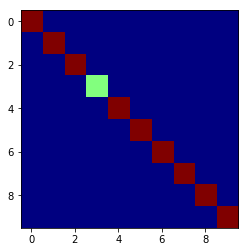

In [61]:
plt.imshow(heatmap)